In [118]:
#  Import a bunch of stuff
import os,sys,inspect, re
from functools import partial
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
import importlib
from datetime import datetime
import soundfile as sf
import librosa

import audio_functions as af
import audio_models
import dataset

In [133]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=16
normalise=True
batch_size = 1
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002
data_type = 'mag_phase'
phase_weight = 0.05
phase_loss_masking = False
phase_loss_approximation = False

checkpoint = '12/12-8'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/MagPhaseMask/checkpoints'
#model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Mixed'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Voice'
directory_c = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Background'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Voice'
#directory_c = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Background'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b, directory_c)
data = get_paired_dataset(data,
                          sample_rate,
                          n_fft,
                          fft_hop,
                          patch_window,
                          patch_hop,
                          n_parallel_readers,
                          batch_size,
                          n_shuffle,
                          normalise)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, background_spec, mixed_audio, voice_audio, background_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)
if data_type == 'mag':
    mixed_input = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
    voice_input = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)
elif data_type in ['mag_phase', 'mag_phase_diff']:
    mixed_input = mixed_spec[:, :, :-1, 2:4]
    voice_input = voice_spec[:, :, :-1, 2:4]
elif data_type == 'real_imag':
    mixed_input = mixed_spec[:, :, :-1, 0:2]
    voice_input = voice_spec[:, :, :-1, 0:2]
elif data_type in ['mag_real_imag', 'mag_phase2']:
    mixed_input = tf.concat([tf.expand_dims(mixed_spec[:, :, :-1, 2], 3), mixed_spec[:, :, :-1, 0:2]], 3)
    voice_input = tf.concat([tf.expand_dims(voice_spec[:, :, :-1, 2], 3), voice_spec[:, :, :-1, 0:2]], 3)
elif data_type in ['mag_phase_real_imag', 'complex_to_mag_phase']:
    mixed_input = mixed_spec[:, :, :-1, :]
    voice_input = voice_spec[:, :, :-1, :]
    
data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

In [132]:
def add_noise(data):
    noise = np.expand_dims(np.random.randn(len(data)), axis=1)
    data_noise = data + 0.01 * noise
    return data_noise

def shift(data):
    return np.roll(data, 3200)

def stretch(data, rate=1):
    input_length = len(data)
    data = librosa.effects.time_stretch(np.squeeze(data), rate)
#    if len(data) > input_length:
#        data = data[:input_length]
#    else:
#        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
    return data

def augment2(data, p):
    if p >= np.random.rand():
        return data
    else:
        aug_func = np.random.randint(3)
        print(aug_func)
        if aug_func == 0:
            return add_noise(data)
        elif aug_func == 1:
            return shift(data)
        elif aug_func == 2:
            return stretch(data, 0.75)
        
def augment(audio_a, audio_b, audio_c, p):
    if p > np.random.rand():
        aug_func = np.random.randint(3)
        if aug_func == 0:
            audio_a = tf.py_func(add_noise, [audio_a], tf.float32, stateful=False)
        elif aug_func == 1:
            audio_a = tf.py_func(shift, [audio_a], tf.float32, stateful=False)
            audio_b = tf.py_func(shift, [audio_b], tf.float32, stateful=False)
            audio_c = tf.py_func(shift, [audio_c], tf.float32, stateful=False)
        elif aug_func == 2:
            audio_a = tf.py_func(stretch, [audio_a, 0.75], tf.float32, stateful=False)
            audio_b = tf.py_func(stretch, [audio_b, 0.75], tf.float32, stateful=False)
            audio_c = tf.py_func(stretch, [audio_c, 0.75], tf.float32, stateful=False)
    return audio_a, audio_b, audio_c

In [33]:
file = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Voice/F01_22GC010A_BTH.CH1.wav'
audio = af.read_audio_py(file, sample_rate)
#audio = audio[20000:25000]

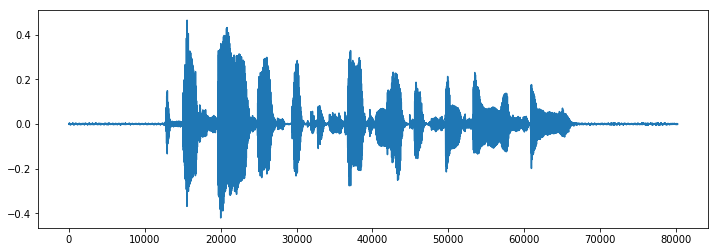

In [34]:
x = range(len(audio))
plt.figure(figsize=(12,4))
plt.plot(x,audio)
ipd.Audio(audio.T, rate=sample_rate)

In [35]:
noisy_audio = add_noise(audio)

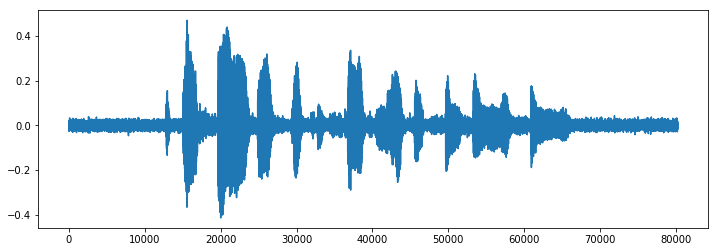

In [36]:
plt.figure(figsize=(12,4))
plt.plot(x,noisy_audio)
ipd.Audio(noisy_audio.T, rate=sample_rate)

In [41]:
shifted_audio = shift(audio)

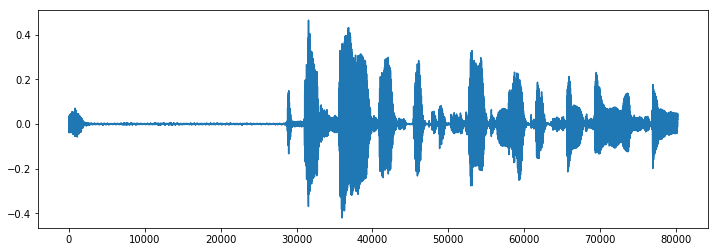

In [42]:
plt.figure(figsize=(12,4))
plt.plot(x,shifted_audio)
ipd.Audio(shifted_audio.T, rate=sample_rate)

In [53]:
stretched_audio = stretch(np.squeeze(audio),0.75)

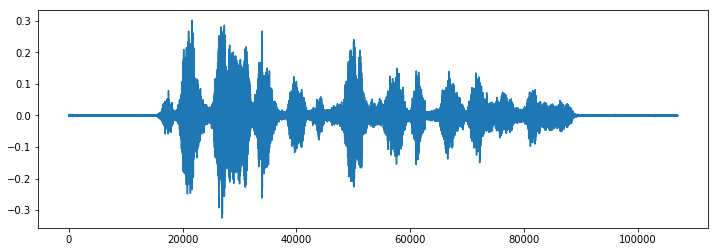

In [54]:
x_stretch = range(len(stretched_audio))
plt.figure(figsize=(12,4))
plt.plot(x_stretch,stretched_audio)
ipd.Audio(stretched_audio.T, rate=sample_rate)

In [137]:
def get_paired_dataset(zipped_files,
                       sample_rate,
                       n_fft,
                       fft_hop,
                       patch_window,
                       patch_hop,
                       n_parallel_readers,
                       batch_size,
                       n_shuffle,
                       normalise):
    """
    Returns a data pipeline (now tripple, rather than pair) of spectrogram and audio files
    """
    return (
        tf.data.Dataset.from_tensor_slices((zipped_files[:, 0], zipped_files[:, 1], zipped_files[:, 2]))
        .map(partial(af.read_audio_triple,
                     sample_rate=sample_rate),
             num_parallel_calls=n_parallel_readers)
        .map(partial(augment,
                    p=1),
             num_parallel_calls=n_parallel_readers)
        .map(partial(af.extract_audio_patches_map,
                     fft_hop=fft_hop,
                     patch_window=patch_window,
                     patch_hop=patch_hop,),
             num_parallel_calls=n_parallel_readers)
        .flat_map(af.zip_tensor_slices)
        .map(partial(af.compute_spectrogram_map,
                     n_fft=n_fft,
                     fft_hop=fft_hop,
                     normalise=normalise),
             num_parallel_calls=n_parallel_readers)
        .shuffle(n_shuffle).batch(batch_size).prefetch(3)
    )


In [138]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(1)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

In [139]:
sess.run(pipe.initializer)
mixed, voice, bg = sess.run([mixed_audio, voice_audio, background_audio])

InvalidArgumentError: 0-th value returned by pyfunc_30 is double, but expects float
	 [[{{node PyFuncStateless}} = PyFuncStateless[Tin=[DT_FLOAT], Tout=[DT_FLOAT], token="pyfunc_30"](arg0)]]
	 [[{{node IteratorGetNext}} = IteratorGetNext[output_shapes=[[?,256,513,4], [?,256,513,4], [?,256,513,4], [?,65280,1], [?,65280,1], [?,65280,1]], output_types=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](IteratorV2)]]

In [ ]:
x_stretch = range(len(mixed[0]))
plt.figure(figsize=(12,4))
plt.plot(x_stretch,mixed[0])
ipd.Audio(mixed[0].T, rate=sample_rate)

In [ ]:
x_stretch = range(len(voice[0]))
plt.figure(figsize=(12,4))
plt.plot(x_stretch,voice[0])
ipd.Audio(voice[0].T, rate=sample_rate)